<a href="https://colab.research.google.com/github/ajwimmers/GeoIPS/blob/master/colab_notebooks/Notebook07_CNNs_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Notebook 07: Convolutional Neural Networks



### Primary Goal:
Build and train a convolutional neural network



#### Background
Now that we have thoroughly discussed what a convolution is, we will dive into training a convolutional neural network on the ```sub-sevir``` dataset.


#### Step 0
As with all of our notebooks, we will first install packages and grab data.


In [ ]:
#@title Install and unpack files [this will take some time]

print('installing dependencies')
#!pip -q install zenodo-get
!pip -q install zarr
print('grabbing sub-sevir')
#!zenodo_get 7011372
!wget ftp://ftp.ssec.wisc.edu/aisc/sub-sevir.tar.gz
print('unpacking sub-sevir')
!tar -xf sub-sevir.tar.gz
!tar -xf sub-sevir/sub-sevir-train.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-val.tar.gz -C sub-sevir/
!tar -xf sub-sevir/sub-sevir-test.tar.gz -C sub-sevir/
print('grabbing the Github repo')
!git clone https://github.com/ssec/WAF_ML_Tutorial_Part2.git
print('done')


installing dependencies
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 54.9 MB/s eta 0:00:00
grabbing sub-sevir
--2026-02-04 04:41:59--  ftp://ftp.ssec.wisc.edu/aisc/sub-sevir.tar.gz
           => ‘sub-sevir.tar.gz’
Resolving ftp.ssec.wisc.edu (ftp.ssec.wisc.edu)... 144.92.1.6
Connecting to ftp.ssec.wisc.edu (ftp.ssec.wisc.edu)|144.92.1.6|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /aisc ... done.
==> SIZE sub-sevir.tar.gz ... 1974264123
==> PASV ... done.    ==> RETR sub-sevir.tar.gz ... done.
Length: 1974264123 (1.8G) (unauthoritative)

sub-sevir.tar.gz    100%[===================>]   1.84G  5.12MB/s    in 15m 33s 

2026-02-04 04:57:33 (2.02 MB/s) - Control connection closed.
Retrying.

--2026-02-04 05:12:35--  ftp://ftp.ssec.wisc.edu/aisc/sub-sevir.tar.gz
  (try: 2) => ‘sub-sevir.tar.gz’
Connecting to ftp.ssec.

 #### Step 1: Imports

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
print(f"Set random seed: {seed}")

Using device: cuda
Set random seed: 42


 #### Step 2: Load in ```sub-sevir```



 You'll need to update the following paths to the location where you just downloaded the data.

In [ ]:
ds_train = xr.open_dataset('sub-sevir/sub-sevir-train.zarr',engine='zarr')
ds_val = xr.open_dataset('sub-sevir/sub-sevir-val.zarr',engine='zarr')

 By design the ```sub-sevir``` data are 'machine learning ready'. This means that the normalization has already been done (i.e., the features have mean 0 and std 1) and the data are already split into the required groups (train/val/test). So in terms of preparing the data, we only have to pick what features we want to use for training and decide what the learning task is (i.e., classification/regression).

In [ ]:
ds_train


<xarray.Dataset> Size: 3GB
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
  * n_samples       (n_samples) datetime64[ns] 480kB 2018-08-25T00:15:00 ... ...
  * n_channel       (n_channel) <U5 80B 'ir069' 'ir107' 'vil' 'vis'
    id              (n_samples) object 480kB ...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 2GB ...
    label_1d_class  (n_samples) int8 60kB ...
    label_1d_reg    (n_samples) int16 120kB ...
    label_2d_class  (n_samples, x, y) int8 138MB ...
    label_2d_reg    (n_samples, x, y) int16 276MB ...

 #### Step 3: Convert data into PyTorch Datasets



 Before training a machine learning model, we must first convert the data from xarray to a PyTorch `Dataset` object. The first task in this tutorial will be a classification (i.e., "Does this image contain a thunderstorm?"), so we will choose the ```label_1d_class``` variable as our truth data.



 **Important Note:** PyTorch expects images in the channel-first format: `(Channels, Height, Width)`, whereas the data comes in `(Height, Width, Channels)`. We will handle this permutation in our custom Dataset class, `SubSevirDataset`.

In [ ]:
class SubSevirDataset(Dataset):

    # When SubSevirDataset is first initialized as an object, set up the "features" and
    # "labels" attributes from variables in the input xarray dataset:
    def __init__(self, xarray_dataset):
        self.features = xarray_dataset.features.values
        self.labels = xarray_dataset.label_1d_class.values

    # When applying len() to a SubSevirDataset object, use the length of the "labels"
    # attribute:
    def __len__(self):
        return len(self.labels)

    # This method defines what happens when PyTorch asks for sample number idx.
    # Usually this only happens behind the scenes, but it is necessary for PyTorch to access
    # the data properly.
    def __getitem__(self, idx):

        # Grab data for index
        x = self.features[idx] # Shape: (48, 48, 4)
        y = self.labels[idx]   # Shape: (1,) or scalar

        # Convert to torch tensor
        x = torch.from_numpy(x).float()
        y = torch.tensor(y).float()

        # Permute to (Channels, Height, Width) -> (4, 48, 48)
        x = x.permute(2, 0, 1)

        return x, y

# Create Datasets
train_dataset = SubSevirDataset(ds_train)
val_dataset = SubSevirDataset(ds_val)


 #### Step 4: Create a `DataLoader`



 The concept of a DataLoader is central to PyTorch.



 To help the machine learning converge on a solution in a timely manner, PyTorch will need to estimate how to adjust the weights of the model (i.e., the gradient of the model with respect to the error) using some *random subset* of the total training data (i.e., batch). This is accomplished by shuffling the data every epoch and randomly selecting batches. PyTorch's `DataLoader` class handles this batching and shuffling for us.

In [ ]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Frequently asked question: "How do I look at the data stored in a `DataLoader`?"



 We can *iterate* over this loader. The following code will loop once to get the first batch.

In [ ]:
# Get a single batch
data_iter = iter(train_loader)
features_batch, labels_batch = next(data_iter)


In [ ]:
# Check shapes
print("Features shape:", features_batch.shape) # Should be [32, 4, 48, 48]
print("Labels shape:", labels_batch.shape)     # Should be [32]


Features shape: torch.Size([32, 4, 48, 48])
Labels shape: torch.Size([32])


 Now you can see that a batch is a collection of 32 images and labels. Note the shape `[32, 4, 48, 48]` which corresponds to `[Batch, Channels, Height, Width]`.



 We can visualize just one example to show the whole process. We need to permute the dimensions back to `[Height, Width, Channels]` for matplotlib plotting.

Label: 1.0


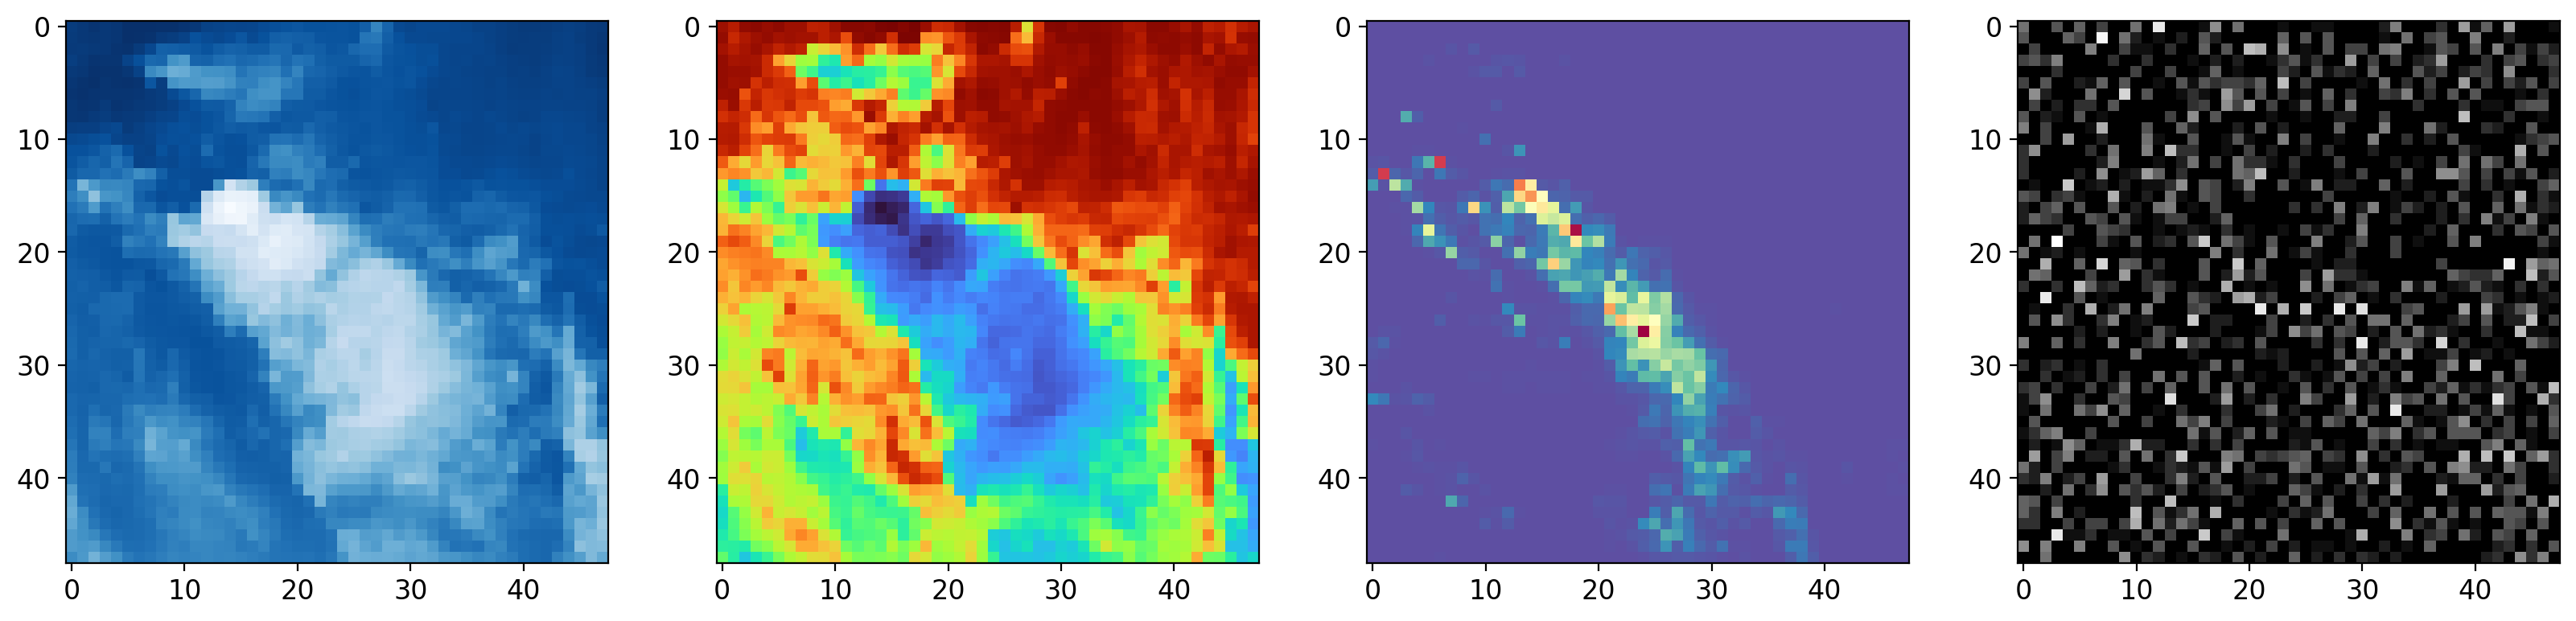

In [ ]:
# Get the features for example 12 in this batch
# Permute back to (H, W, C) for plotting: (1, 2, 0)
one_example_features = features_batch[12].permute(1, 2, 0)
# Get the label for that same example
one_example_label = labels_batch[12]


fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

print(f"Label: {one_example_label.item()}")


 There ya go! Now you have a way to dig into the data when they are in this DataLoader form.



 Just know that if you recreate the iterator or loop again, you will get a new (random) batch.

 #### Step 5: Build CNN model



 We will define a Python class inheriting from `nn.Module` to build our CNN.



 Let's start simple with the following. (Although this this "simple," many of the elements are nonintuitive at the beginning, so take it slow.)



 a) A single convolutional layer with 3x3 filters, 4 input channels and 1 output map (see Notebook 6b),

 b) A RelU activation on the output map,

 c) Flattening the activation map into 2216 individual *features*,

 d) A fully connected layer (see Notebook 5) that combines the values of these features into a weighted sum (plus an offset), and

 e) A sigmoid function that converts this variable into an output that conveniently ranges from 0 to 1.


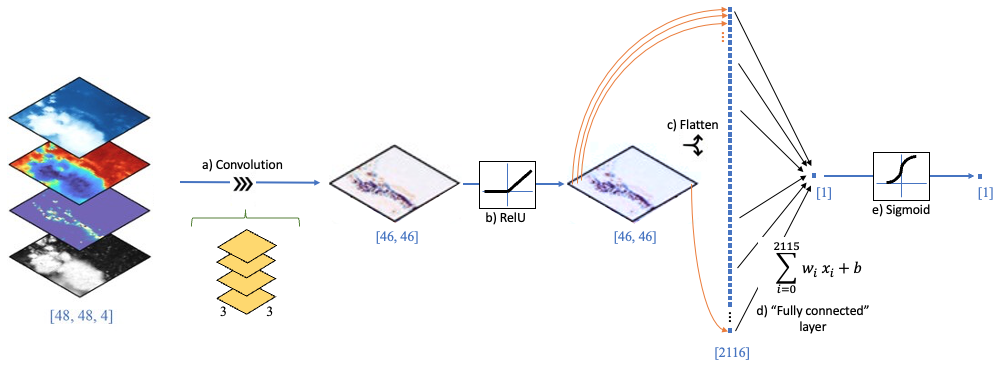

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):

        # This class SimpleCNN inherits the properties of the PyTorch
        # class nn.Module (the superclass given in the first line)
        super(SimpleCNN, self).__init__()

        # Give the specs of the method, "conv1"
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)

        # RelU activation
        self.relu1 = F.relu

        # Give the specs of the method "flatten"
        self.flatten = nn.Flatten()  # flatten 2d output to 1d vector

        # We need to calculate the input size for the dense (or "fully connected") layer.
        # Input (48, 48) -> Conv2d(kernel=3, no padding) -> Output (46, 46)
        # 46 * 46 * 1 = 2116
        self.fc = nn.Linear(46 * 46, 1)

        # Final sigmoid activation that forces output to range from 0 to 1
        self.sigmoid = nn.Sigmoid()

    # As a reminder, this method instructs PyTorch how to order the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

import torch.nn.functional as F

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2116, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


 #### Step 6: Run some data through



 It can be useful to run your data through the untrained model to see how it performs with completely random weights.

(0.0, 1.0)

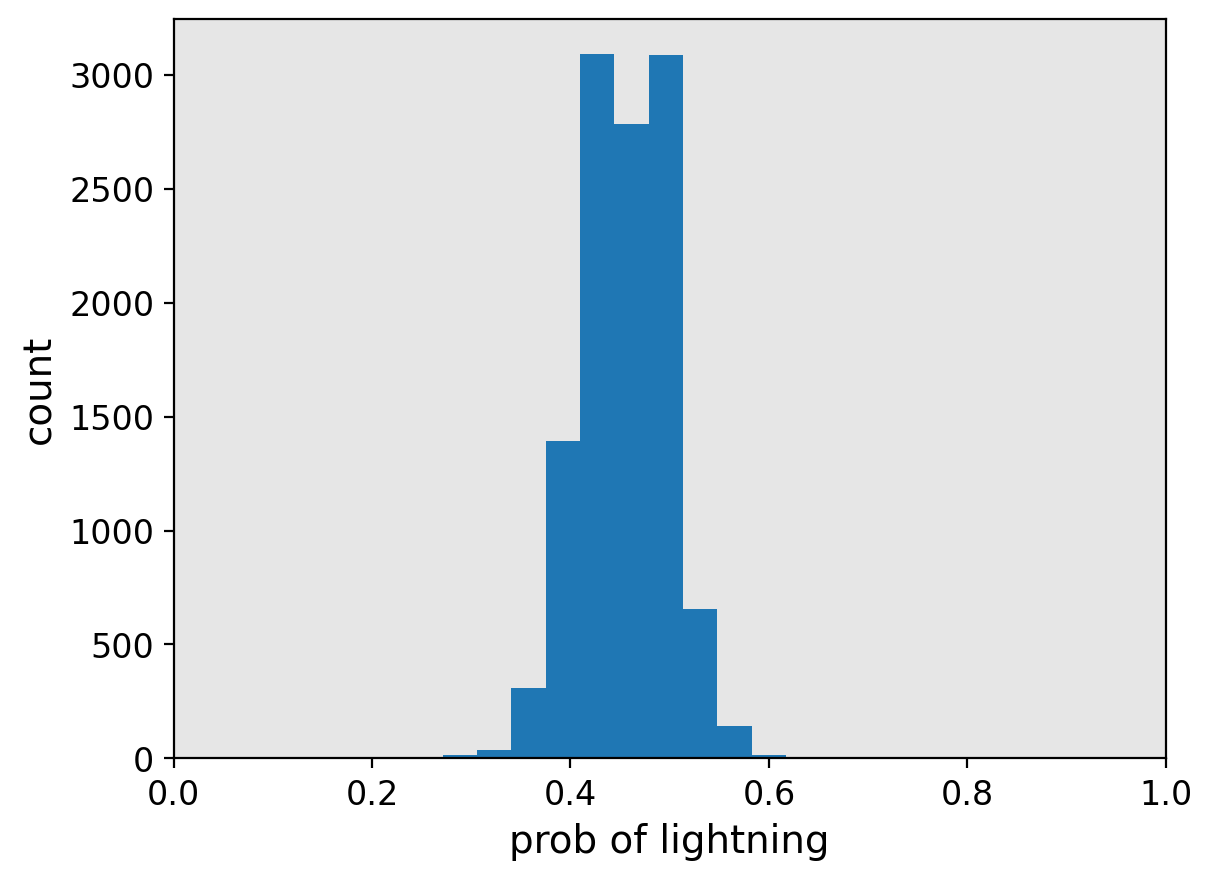

In [ ]:
# Helper function to get predictions
def get_predictions(loader, model):
    model.eval() # Set model to evaluation mode
    all_preds = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            preds = model(inputs)
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_preds).flatten()

y_preds = get_predictions(val_loader, model)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


 As expected, the model is producing predictions [0,1], and the predictions generally fall in the middle of the probability distribution.



 Let's take a look at the performance diagram. To do that, we first need to extract the truth labels from our validation set.

In [ ]:
y_v = ds_val.label_1d_class.values


In [ ]:
# Calculate performance metrics manually using numpy
thresh = np.arange(0.05, 1.05, 0.05)

tps = []
fps = []
fns = []

for t in thresh:
    # Binarize predictions based on threshold
    preds_bin = (y_preds >= t).astype(int)

    # Calculate TP, FP, FN
    tp = np.sum((preds_bin == 1) & (y_v == 1))
    fp = np.sum((preds_bin == 1) & (y_v == 0))
    fn = np.sum((preds_bin == 0) & (y_v == 1))

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)

# Calc x,y of performance diagram
# Avoid division by zero
pods = np.divide(tps, (tps + fns), out=np.zeros_like(tps, dtype=float), where=(tps + fns)!=0)
srs = np.divide(tps, (tps + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fps)!=0)
csis = np.divide(tps, (tps + fns + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fns + fps)!=0)


/content/WAF_ML_Tutorial_Part2/scripts/gewitter_functions.py:417: SyntaxWarning: invalid escape sequence '\l'
  pretty_names = [ '$\lambda_{\downarrow}$', '$T_{d}$', '$V_{fric}$', 'Gflux', '$Cloud_{high}$',
/content/WAF_ML_Tutorial_Part2/scripts/gewitter_functions.py:419: SyntaxWarning: invalid escape sequence '\l'
  'Hours $T_{sfc}$ $>$ 0', 'Hours $T_{sfc} \leq 0$', 'SfcRough', '$T_{sfc}$',
/content/WAF_ML_Tutorial_Part2/scripts/gewitter_functions.py:420: SyntaxWarning: invalid escape sequence '\l'
  '$I_{S}$', '$T_{2m}$', 'Hours $T_{2m}$ $>$ 0', 'Hours $T_{2m}$ $\leq $ 0',


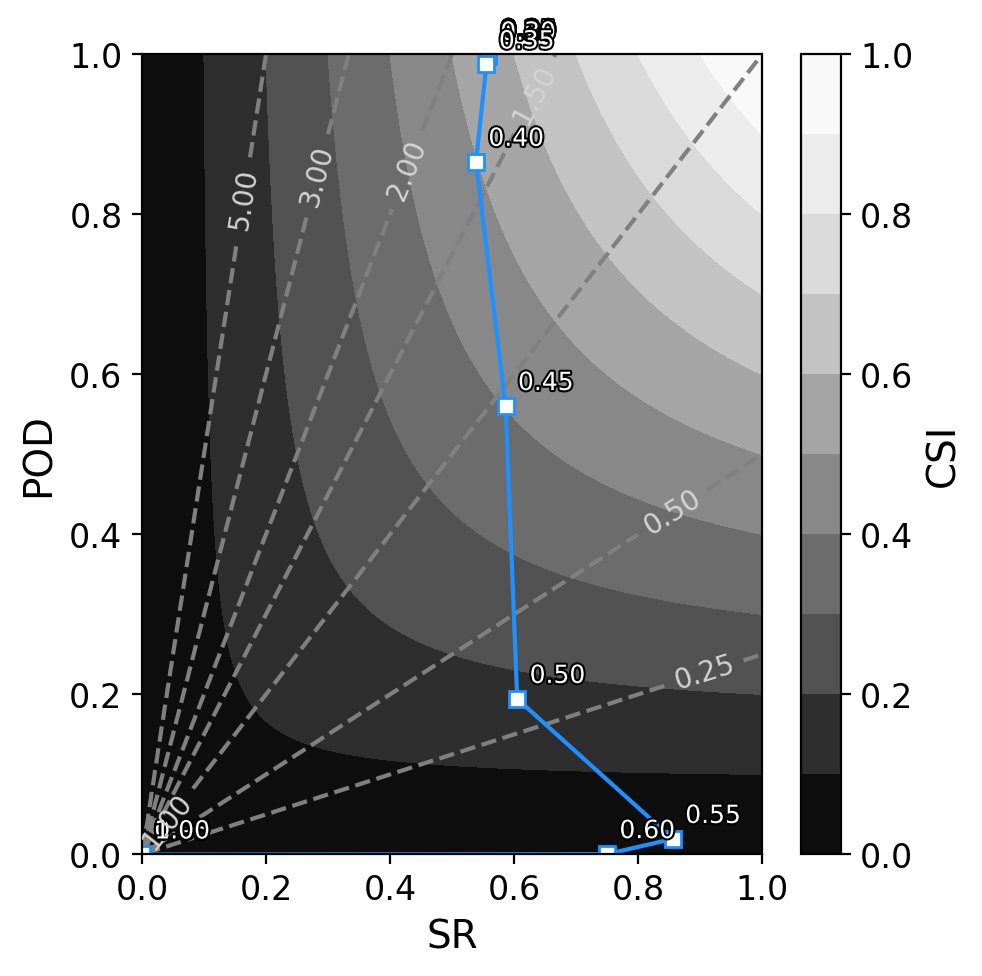

In [ ]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, 'WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import make_performance_diagram_axis

#plot it up
ax = make_performance_diagram_axis()
ax.plot(srs, pods, '-s', color='dodgerblue', markerfacecolor='w', label='UNET')

for i, t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
    ax.text(srs[i]+0.02, pods[i]+0.02, text, path_effects=pe1, fontsize=9, color='white')

plt.tight_layout()


 There are some funky things to note with this performance diagram. It might seem like random weights work well, but remember that the validation dataset is roughly balanced (no lightning: 44%; lightning: 56%), so even a random guess can demonstrate decent performance. Also notice how the curve appears disjointed.



 If you want to view the convolution filters, you can access the weights of the layer directly:

In [ ]:
# Grab layer 1 weights
filters = model.conv1.weight.data.cpu().numpy()

# PyTorch weights are (Out_Channels, In_Channels, H, W) -> (1, 4, 3, 3)
print(filters.shape)


(1, 4, 3, 3)


 Let's take a look at each of the filters (channels).

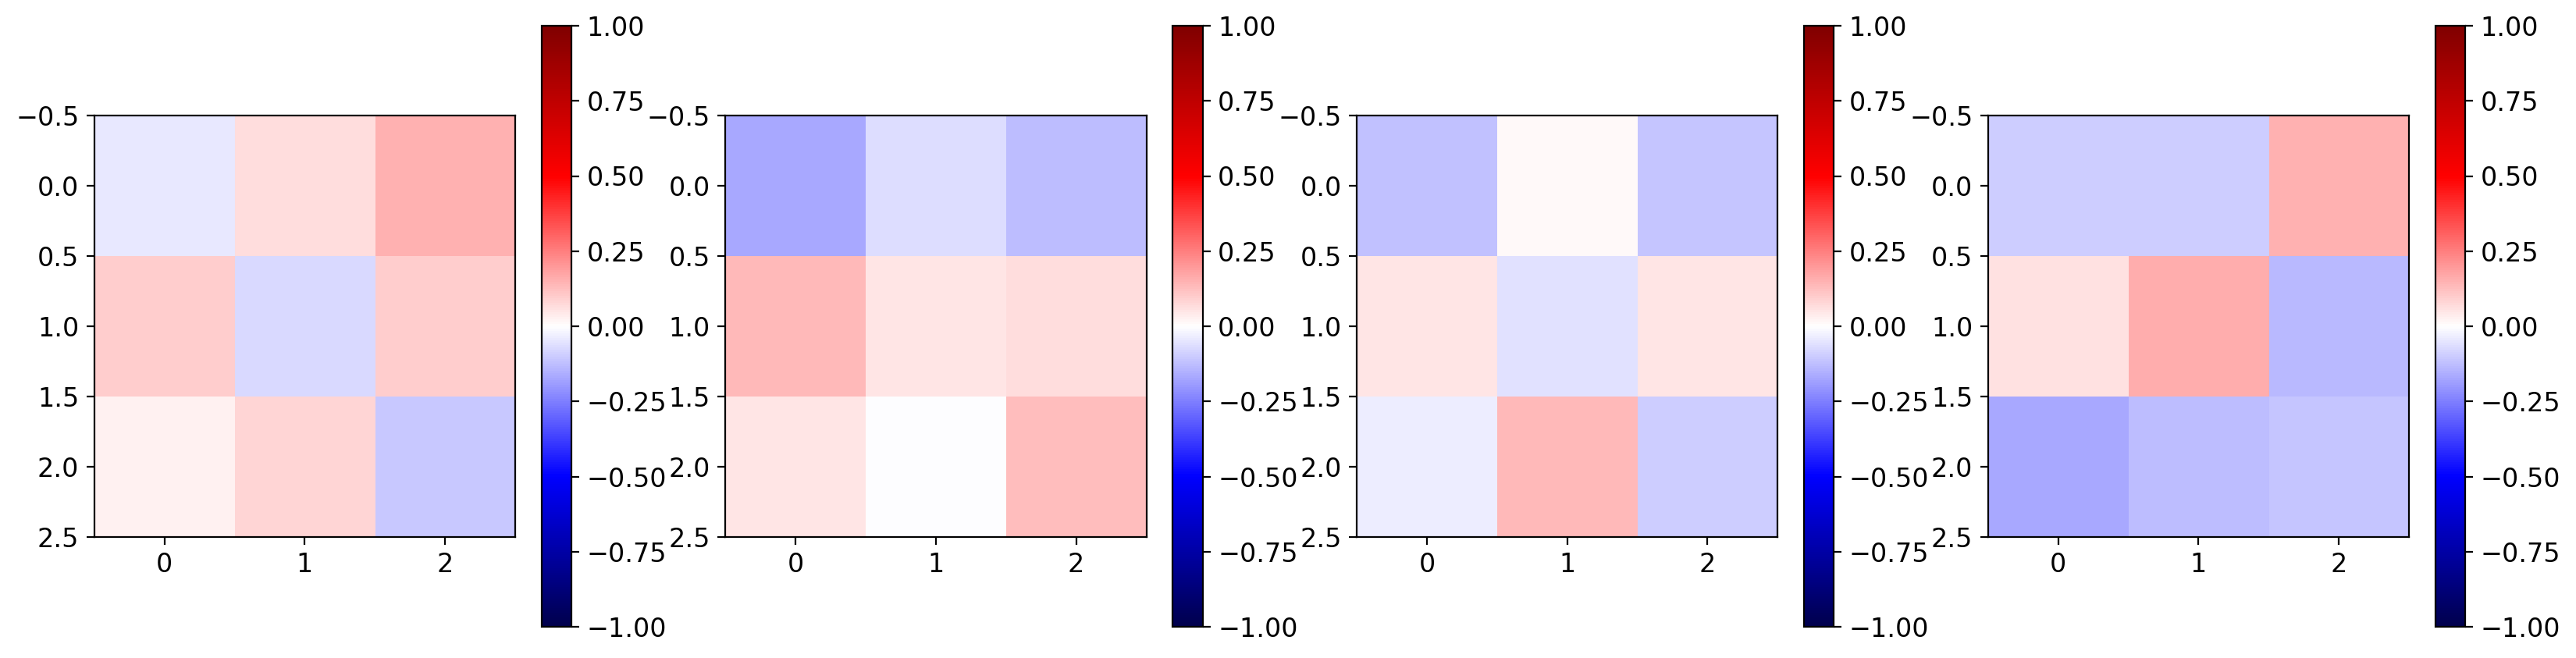

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Iterate over the input channels (second dimension)
for i in range(4):
    # filters[0, i, :, :] gives the filter for the ith input channel
    pm = axes[i].imshow(filters[0, i, :, :], vmin=-1, vmax=1, cmap='seismic')
    plt.colorbar(pm, ax=axes[i])



 This really isn't very informative, but you can see how the values are approximately equally distributed around 0. This distribution is provided in the initialization step when first creating the model.



 Maybe looking at the output of the convolutional layer will help? We can do this by creating a hook or simply passing data through the first part of the model manually.



In [ ]:
# Run the model conv layer only
# Grab a batch to look at
data_iter = iter(val_loader)
features, labels = next(data_iter)

# Move to device
features = features.to(device)

# Pass through conv1
with torch.no_grad():
    convolved_images = model.conv1(features)

convolved_images = convolved_images.cpu().numpy()


Label: 1.0


Text(0.5, 1.0, 'Feature map from first convolution')

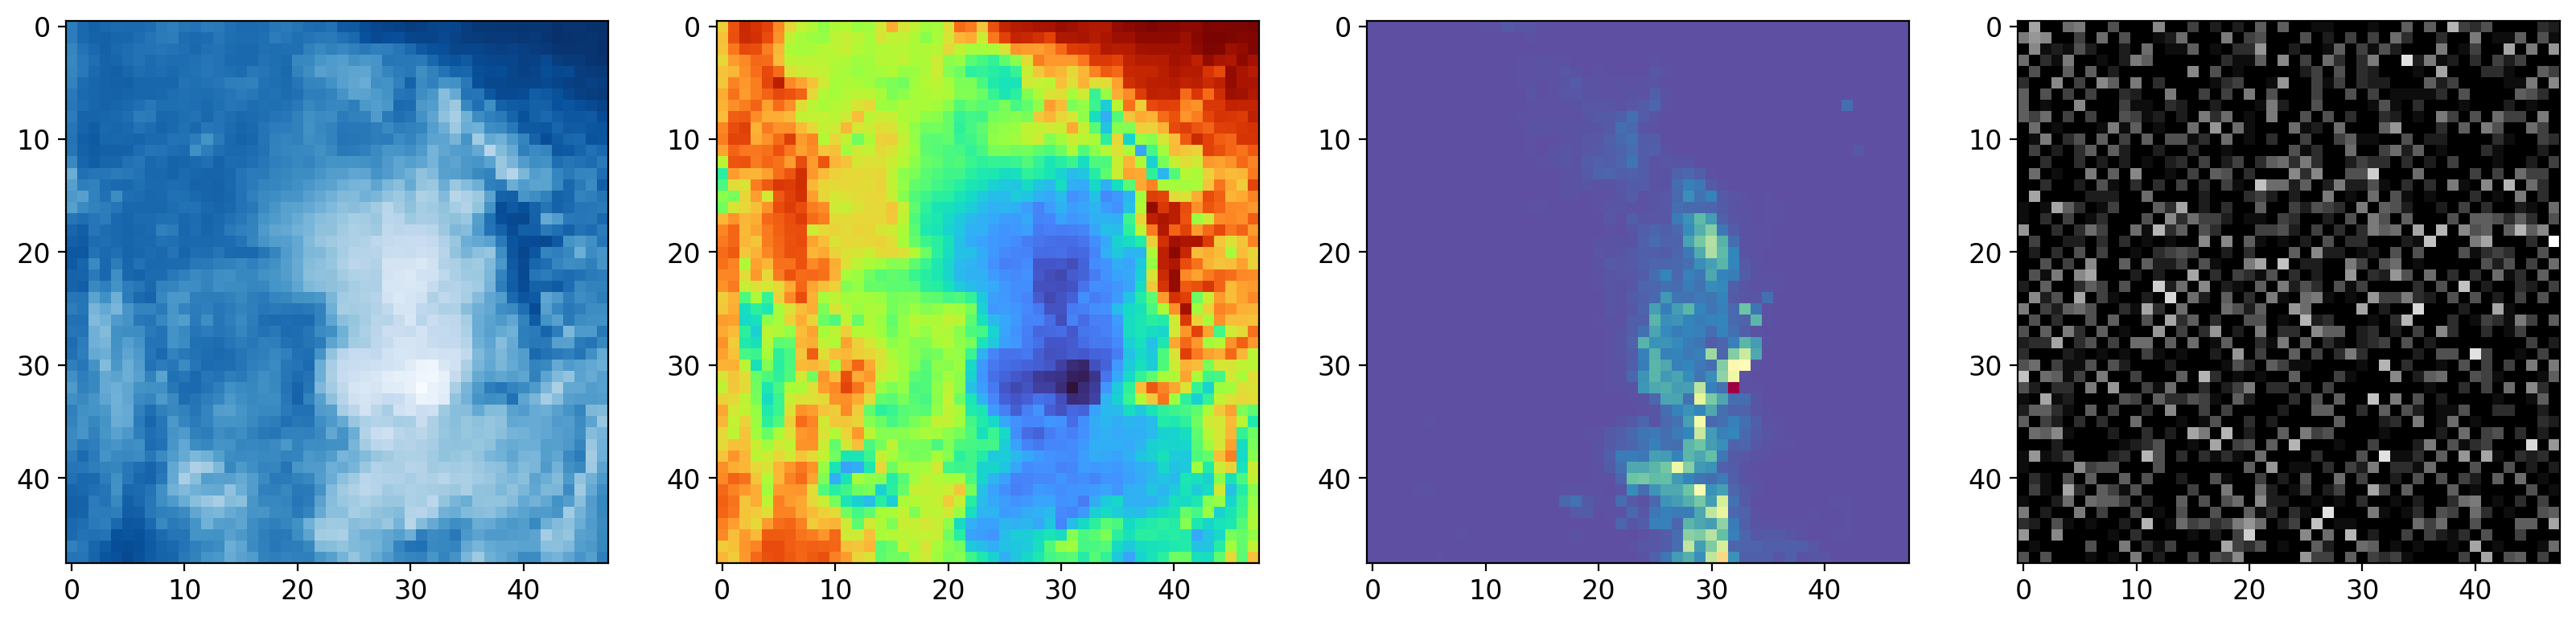

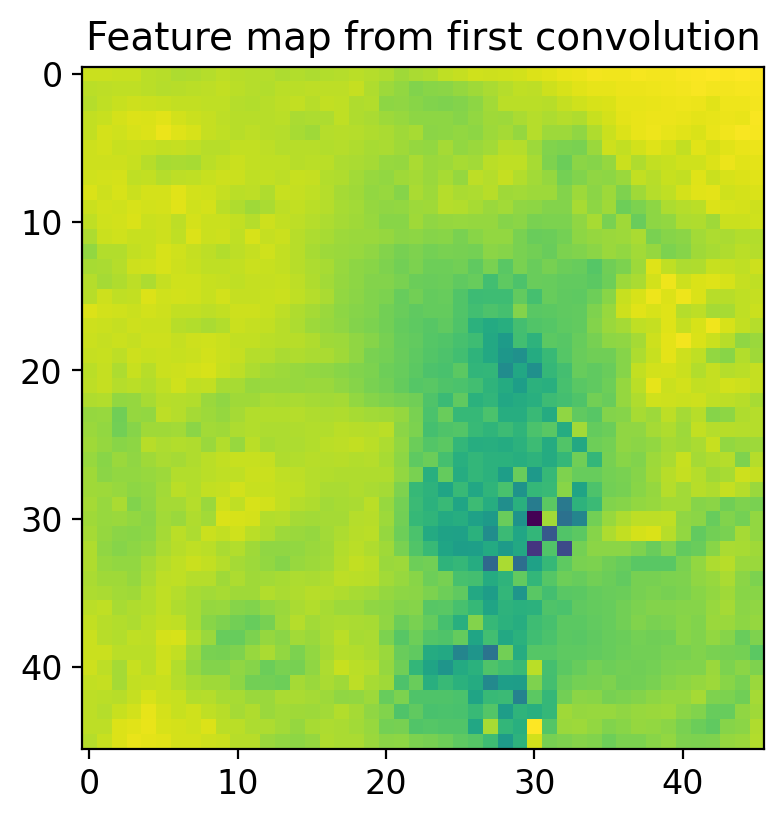

In [ ]:
# Get the features for example 0 in this batch
one_example_features = features[0].permute(1, 2, 0).cpu() # Back to H,W,C for plotting
one_example_label = labels[0]

fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

print(f"Label: {one_example_label}")

plt.figure(figsize=(4.4,5))
# Convolved image shape is (Batch, Out_Channels, H, W).
# We want example 0, channel 0:
plt.imshow(convolved_images[0, 0, :, :])
plt.title('Feature map from first convolution')


 Notice that even for completely random filter weights (i.e., no training), the CNN still highlights the region where a storm is. This is probably why the performance diagram looks decent.

 #### Step 7: Train the model for 20 epochs



 Okay, enough digging in the weeds. Let's write our training loop!

In [ ]:
model = SimpleCNN().to(device) # This resets the parameters every time you run this block.

# This is the loss function, "binary cross-entropy". It is an efficient penalty for
# probabilities that depart from the 0, 1 probability of their target categories
criterion = nn.BCELoss()

# Every model must use a system for adapting its weights iteratively to minimize
# loss. RMSprop is one of the two most popular ones.
optimizer = optim.RMSprop(model.parameters(), lr=2e-3)

epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train() # Set to train mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Zero gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs.squeeze(), labels) # Calculate loss
        loss.backward() # Backprop
        optimizer.step() # Update weights

        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval() # Set to eval mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 1/20 - Loss: 0.3652 - Val Loss: 0.2977
Epoch 2/20 - Loss: 0.3163 - Val Loss: 0.3315
Epoch 3/20 - Loss: 0.3109 - Val Loss: 0.3007
Epoch 4/20 - Loss: 0.3037 - Val Loss: 0.3660
Epoch 5/20 - Loss: 0.3058 - Val Loss: 0.3209
Epoch 6/20 - Loss: 0.3046 - Val Loss: 0.3376
Epoch 7/20 - Loss: 0.3117 - Val Loss: 0.3434
Epoch 8/20 - Loss: 0.3079 - Val Loss: 0.3464
Epoch 9/20 - Loss: 0.3125 - Val Loss: 0.3505
Epoch 10/20 - Loss: 0.3093 - Val Loss: 0.3455
Epoch 11/20 - Loss: 0.3091 - Val Loss: 0.3575
Epoch 12/20 - Loss: 0.3127 - Val Loss: 0.3799
Epoch 13/20 - Loss: 0.3073 - Val Loss: 0.3993
Epoch 14/20 - Loss: 0.3143 - Val Loss: 0.3966
Epoch 15/20 - Loss: 0.3119 - Val Loss: 0.3813
Epoch 16/20 - Loss: 0.3116 - Val Loss: 0.4177
Epoch 17/20 - Loss: 0.3203 - Val Loss: 0.4170
Epoch 18/20 - Loss: 0.3101 - Val Loss: 0.4206
Epoch 19/20 - Loss: 0.3140 - Val Loss: 0.4112
Epoch 20/20 - Loss: 0.3200 - Val Loss: 0.4450


 Depending on your computer, this might take some time to run.



 #### Step 8: Check for overfitting



 As always, we should probably check to see if the model is overfitting. To do this, let's plot the loss curves for both the training data and the validation data:

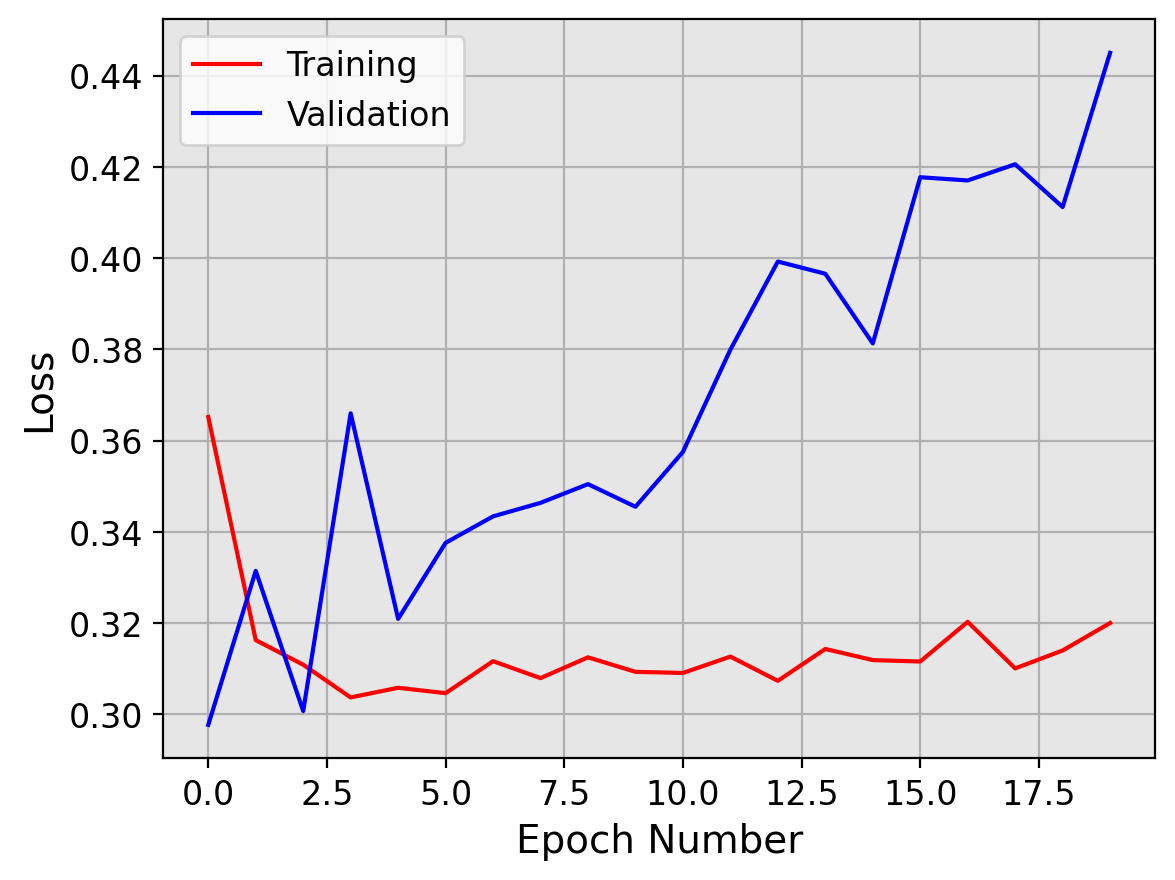

In [ ]:
plt.plot(train_losses, '-r', label='Training')
plt.plot(val_losses, '-b', label='Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()


 Take a moment and consider if overfitting has occurred. Remember, you are looking to see if the red line continues to decrease while the blue line increases.

 This example is a pretty extreme case of overfitting. The validation loss is growing rapidly with nearly each epoch.



 #### Step 9: Check performance



 To check the performance, we can reuse the same code from earlier in this tutorial:

(0.0, 1.0)

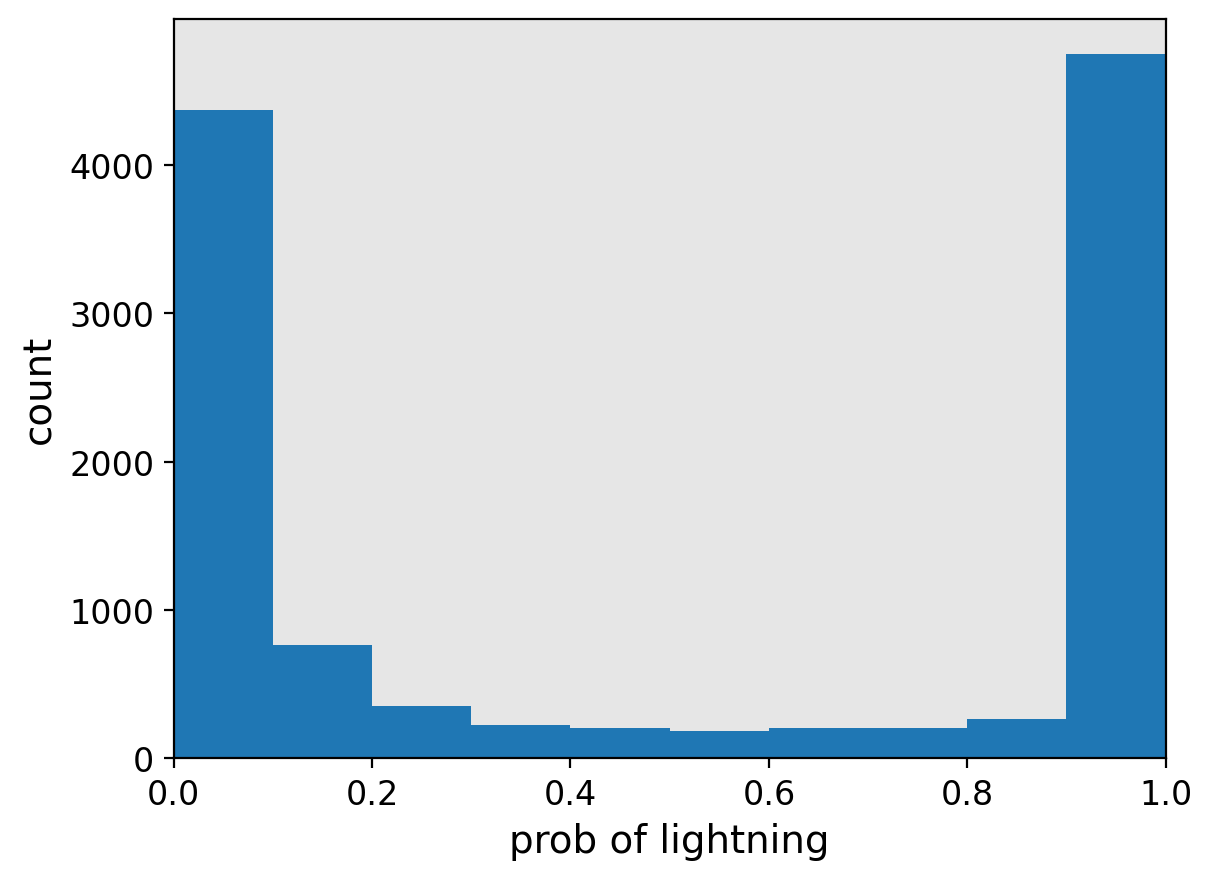

In [ ]:
y_preds = get_predictions(val_loader, model)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])


 Here we can see there is a good grouping of examples where the model predicts class probabilities near 0 and 1, and then there are relatively few cases where the output of the model is more in the middle of the distribution (i.e., more uncertain).



 Let's make the performance diagram again:

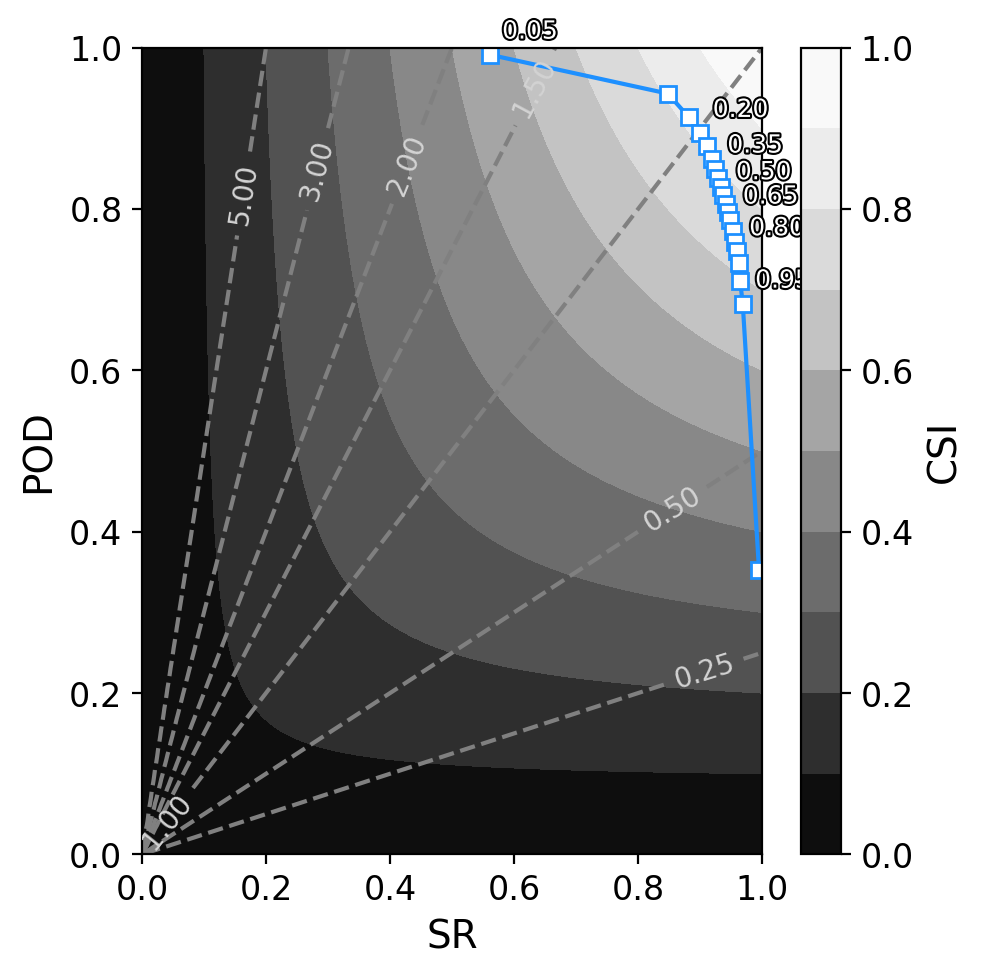

In [ ]:
thresh = np.arange(0.05, 1.05, 0.05)

tps = []
fps = []
fns = []

for t in thresh:
    preds_bin = (y_preds >= t).astype(int)
    tps.append(np.sum((preds_bin == 1) & (y_v == 1)))
    fps.append(np.sum((preds_bin == 1) & (y_v == 0)))
    fns.append(np.sum((preds_bin == 0) & (y_v == 1)))

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)

pods = np.divide(tps, (tps + fns), out=np.zeros_like(tps, dtype=float), where=(tps + fns)!=0)
srs = np.divide(tps, (tps + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fps)!=0)
csis = np.divide(tps, (tps + fns + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fns + fps)!=0)

#plot it up
ax = make_performance_diagram_axis()
ax.plot(srs, pods, '-s', color='dodgerblue', markerfacecolor='w', label='UNET')

for i, t in enumerate(thresh):
    if np.mod(i, 3) == 0:
        text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
        ax.text(srs[i]+0.02, pods[i]+0.02, text, path_effects=pe1, fontsize=9, color='white')

plt.tight_layout()


 We get much better results this time. The model has a maximum CSI value of about 0.81 when using a class probability of 0.2 as the deterministic threshold.



 Can we see what filter it learned?

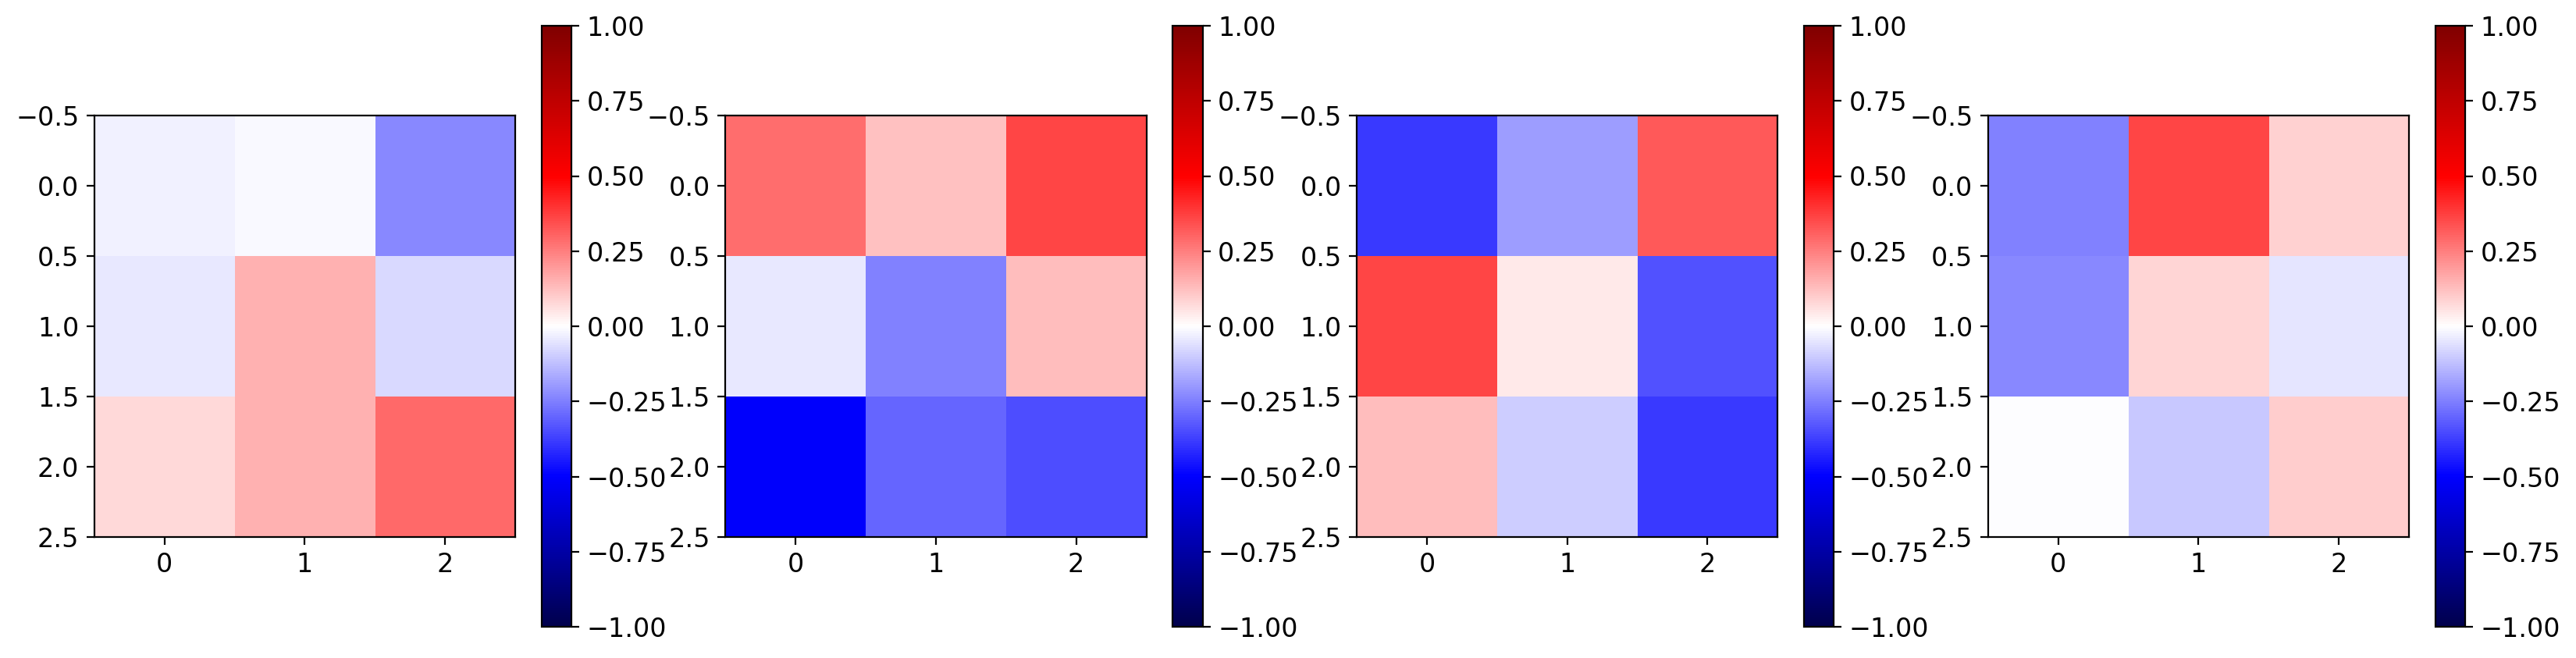

In [ ]:
# Grab layer 1 weights
filters = model.conv1.weight.data.cpu().numpy()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    pm = axes[i].imshow(filters[0, i, :, :], vmin=-1, vmax=1, cmap='seismic')
    plt.colorbar(pm, ax=axes[i])


 As before, it doesn't seem very useful to look at the kernels themselves, so let's look at the output of the convolutional layer instead.

In [ ]:
# Run just the conv layer
data_iter = iter(val_loader)
features, labels = next(data_iter)
features = features.to(device)

with torch.no_grad():
    convolved_images = model.conv1(features)
convolved_images = convolved_images.cpu().numpy()


Label: 1.0


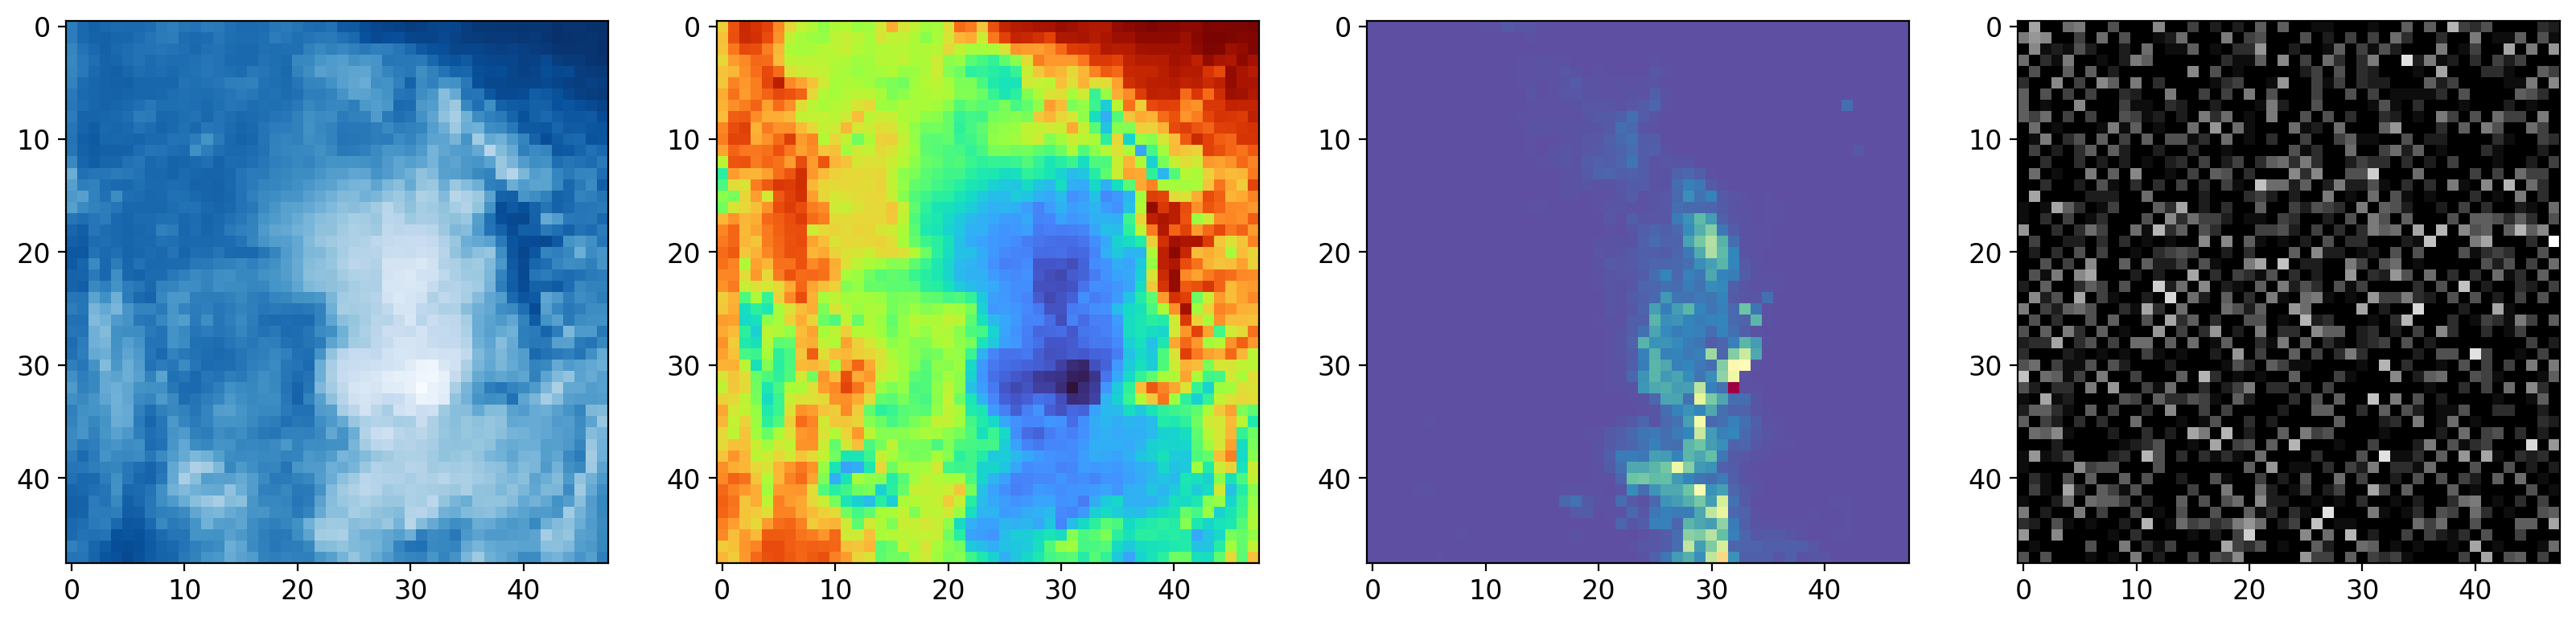

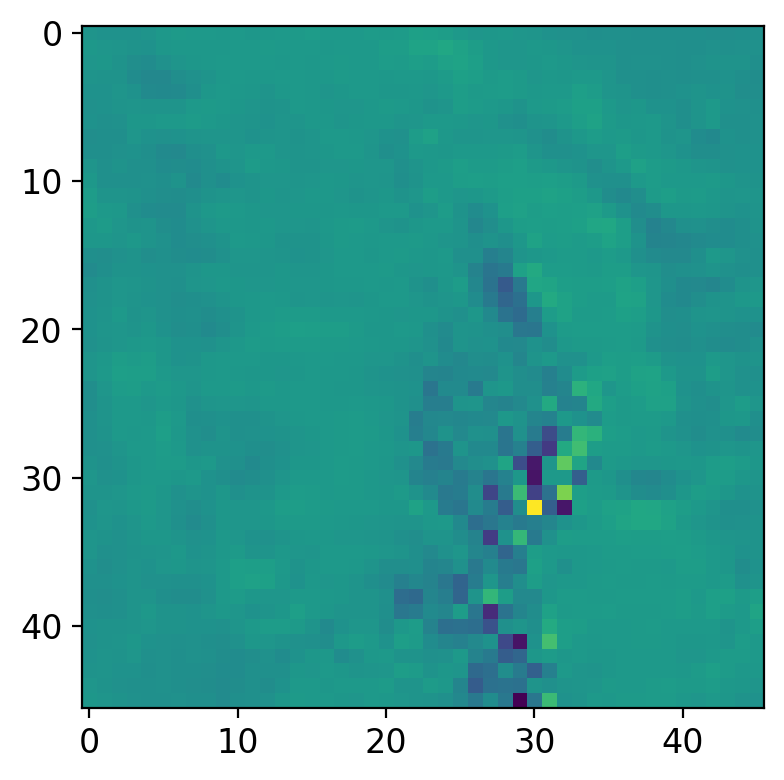

In [ ]:
one_example_features = features[0].permute(1, 2, 0).cpu() # Back to HWC
one_example_label = labels[0]

fig,axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')

print(f"Label: {one_example_label}")

plt.figure(figsize=(4.4,5))
plt.imshow(convolved_images[0, 0, :, :])
plt.title('Feature map from first convolution')


 The result here is actually quite similar to the untrained model, although the convolved data does look a bit more 'focused' in on the area where there are cold cloud tops and high radar values.



 This is probably not a very satisfying explanation for trained model behavior. Thus, later on in this tutorial series there is a notebook discussing more quantitative methods for explaining the CNN.



 #### Step 10: Save the model



 Since this model performs pretty well, let's go ahead and save it.

In [ ]:
torch.save(model.state_dict(), 'WAF_ML_Tutorial_Part2/datasets/models/neural_nets_from_notebooks/MyFirstCNN.pth')


 #### Step 11: Add an ANN



 Typically CNNs have their convolution and maxpool layers, but then after some number of them, the convolutional data is fed through an ANN. This task seems to do well with just a single convolutional layer, but for the sake of completeness, let's add an ANN.

In [ ]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)
        self.flatten = nn.Flatten()

        # Conv output is 46x46
        self.fc1 = nn.Linear(46 * 46, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1) # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) # RelU is so simple it does not need to be defined as a method
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = ComplexCNN().to(device)
print(model)


ComplexCNN(
  (conv1): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2116, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


 Now you can see there are a few more trainable parameters (i.e., weights).



 #### Step 12: Train the new model

In [ ]:
model = ComplexCNN().to(device) # This resets the parameters every time you run this block.

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=2.5e-4)

epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 1/10 - Loss: 0.4953 - Val Loss: 0.4524
Epoch 2/10 - Loss: 0.3783 - Val Loss: 0.4338
Epoch 3/10 - Loss: 0.3378 - Val Loss: 0.4274
Epoch 4/10 - Loss: 0.3102 - Val Loss: 0.4328
Epoch 5/10 - Loss: 0.2853 - Val Loss: 0.4335


KeyboardInterrupt: 

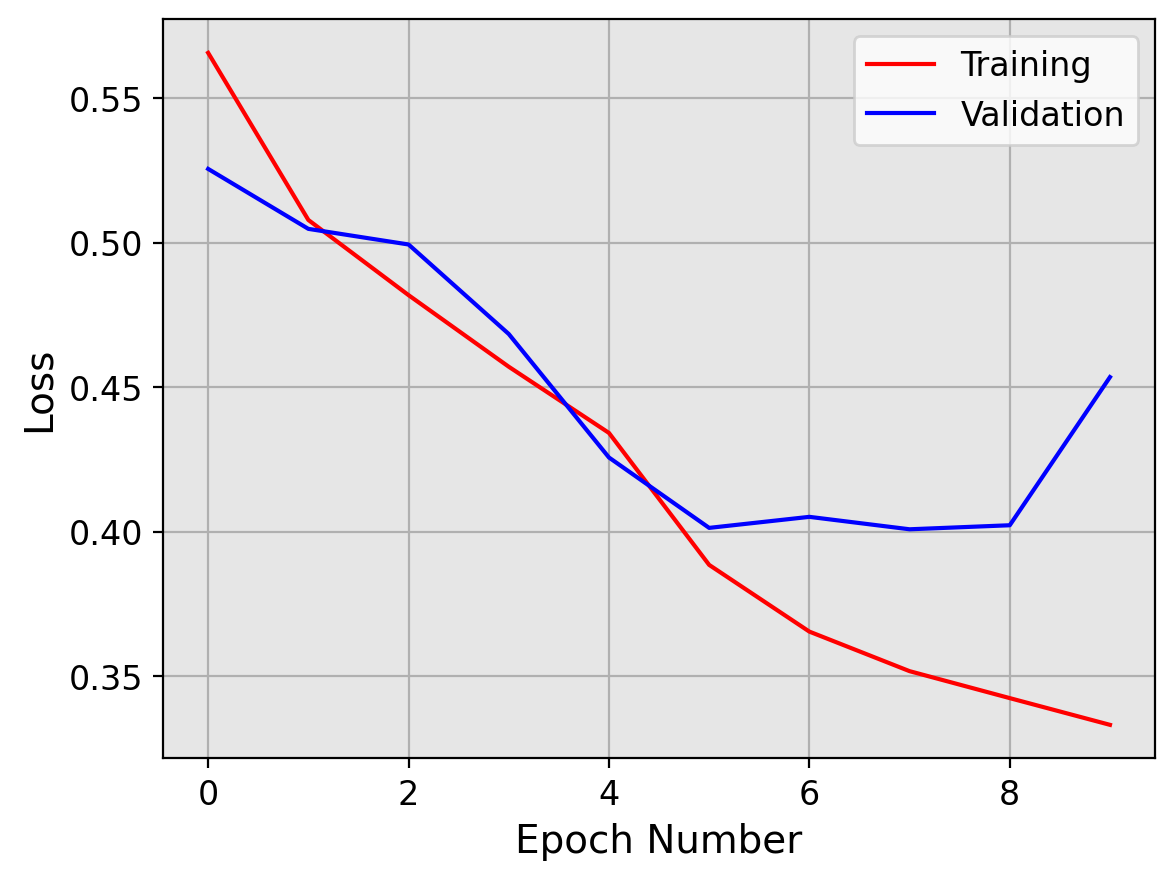

In [ ]:
plt.plot(train_losses, '-r', label='Training')
plt.plot(val_losses, '-b', label='Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()


 This is a clear overfitting signature. It would seem that adding these extra parameters did not help our model. **[NOTE: If you rerun the training block you will get a different result because the initial parameters of the model are randomized each time, and this particular model tends to behave quite differently from one training session to another.]**



 #### Step 13: Add regularization (fix overfitting)



 This is a good time to introduce some regularization tips that can help avoid overfitting. First, let's try adding dropout. This is where neurons are randomly turned on/off to prevent the neural network from memorizing examples (i.e., a specific pathway for a specific example in your training dataset).

In [ ]:
class RegularizedCNN(nn.Module):
    def __init__(self):

        super(RegularizedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(46 * 46, 16)
        self.dropout1 = nn.Dropout(0.33) # 33% dropout

        self.fc2 = nn.Linear(16, 32)
        self.dropout2 = nn.Dropout(0.33) # 33% dropout

        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x) # Apply dropout

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x) # Apply dropout

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = RegularizedCNN().to(device)
print(model)


In [ ]:
model = RegularizedCNN().to(device) # This resets the parameters each time you run this block.
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=2.5e-4)

epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


In [ ]:
plt.plot(train_losses, '-r', label='Training')
plt.plot(val_losses, '-b', label='Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()


As you can see here, the dropout seems to have prevented much of the overfitting signal. However, there may still be some slight overfitting here from about epoch 5 on. **[NOTE: As with the previous model version, if you rerun the training block you will get a different result.]**

The dropout function is sometimes referred to as the "stretchypants" approach. It allows you to build a model that is otherwise too large for it's own good, but because dropout is good at preventing overfitting, the model still fits the data snugly.


 #### Step 14: Check performance again

In [ ]:
# Get predictions
y_preds = get_predictions(val_loader, model)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

# Calculate performance diagram metrics
thresh = np.arange(0.05, 1.05, 0.05)

tps = []
fps = []
fns = []

for t in thresh:
    preds_bin = (y_preds >= t).astype(int)
    tps.append(np.sum((preds_bin == 1) & (y_v == 1)))
    fps.append(np.sum((preds_bin == 1) & (y_v == 0)))
    fns.append(np.sum((preds_bin == 0) & (y_v == 1)))

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)

pods = np.divide(tps, (tps + fns), out=np.zeros_like(tps, dtype=float), where=(tps + fns)!=0)
srs = np.divide(tps, (tps + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fps)!=0)
csis = np.divide(tps, (tps + fns + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fns + fps)!=0)

#plot it up
ax = make_performance_diagram_axis()
ax.plot(srs, pods, '-s', color='dodgerblue', markerfacecolor='w', label='UNET')

for i, t in enumerate(thresh):
    if np.mod(i, 3) == 0:
        text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
        ax.text(srs[i]+0.02, pods[i]+0.02, text, path_effects=pe1, fontsize=9, color='white')

plt.tight_layout()


 There ya go! You have trained a more typical CNN structure.

#### Step 14: Practice with a normal CNN architecture.

Up to now we have worked with model architectures that are easier to follow but not necessarily using best practices for design. This last example is more like a model that you can refer to for your own applications. It is also very similar to the architecture in the next notebook, so there will be less adjustment when you get to that.

There are a few new concepts introduced all together in this next code block, so it's necessary to identify them first:

**Blocks**: When sequences of network layers are used repeatedly, it is better to organize them as "blocks." This streamlines the code, and makes the whole model easier to follow once you get the hang of it.

**BatchNorm**: This is a tool that helps prevent blowups in the model. You can learn more about it later.

**MaxPool**: This reduces the spatial size of a feature map while preserving the most prominent responses. A 2x2 max-pool does this by keeping only the largest value in each small region.

This brings us to the most important term in this section, **downscaling**. Downscaling is critical to the design of CNNs. Consider this common, compressed approach to diagramming a CNN:

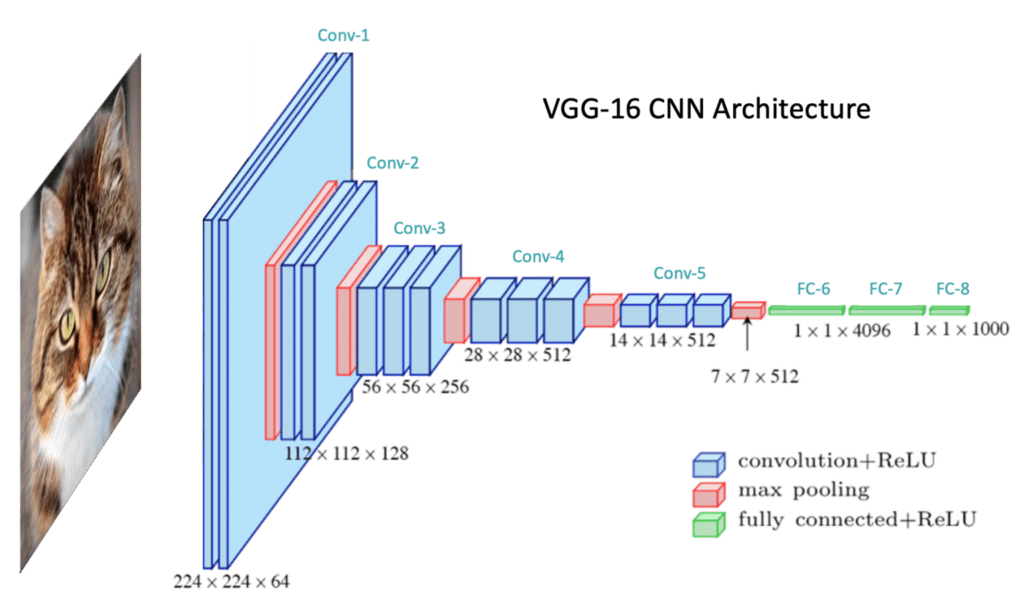

From Convolutional Neural Network (CNN): A Complete Guide, by Bill Kromydas, learnopencv.com.

(We all knew we'd get to a cat picture at some point.)

The strategy behind this architecture, which is common to most CNNs, is that the information from the image reduces spatially by a factor of 4 at each block (1/2 height and 1/2 width), while it increases by 2 in feature depth. This allows the model to work at greater and greater levels of abstraction while also compressing the information over the sequence of operations. When the model reaches a scale at which the feature map is sufficiently deep and also no longer has any important spatial structure (roughly around 7 pixels x 7 pixels), *then* it is appropriate to flatten the feature maps and process the elements as a simple array.


In [ ]:
# Double convolution block:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Downscaling block:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# CNN model
class TypicalCNN(nn.Module):
    def __init__(self, n_channels):
        super(TypicalCNN, self).__init__()
        self.n_channels = n_channels

        # Input channels: 4 (features)
        # We start with 8 filters (can be adjusted, 16 is common)
        self.inc = DoubleConv(n_channels, 8)     # -> 48x48
        self.down1 = Down(8, 16)                 # -> 24x24
        self.down2 = Down(16, 32)                # -> 12x12
        self.down3 = Down(32, 64)                # ->  6x6

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(6*6*64, 16)
        self.dropout1 = nn.Dropout(0.20) # 20% dropout

        self.fc2 = nn.Linear(16, 1)
        self.dropout2 = nn.Dropout(0.20) # 20% again
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.sigmoid(x)
        return x

import torch.nn.functional as F

model = TypicalCNN(n_channels=4).to(device)
print(model)


TypicalCNN(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momen

Train the model:



In [ ]:
model = TypicalCNN(n_channels=4).to(device) # This resets the parameters each time you run this block.
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=2e-4)

epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 1/10 - Loss: 0.3537 - Val Loss: 0.2564
Epoch 2/10 - Loss: 0.3161 - Val Loss: 0.2322
Epoch 3/10 - Loss: 0.3007 - Val Loss: 0.2260
Epoch 4/10 - Loss: 0.2889 - Val Loss: 0.2304
Epoch 5/10 - Loss: 0.2767 - Val Loss: 0.2289
Epoch 6/10 - Loss: 0.2680 - Val Loss: 0.2374
Epoch 7/10 - Loss: 0.2574 - Val Loss: 0.2578
Epoch 8/10 - Loss: 0.2513 - Val Loss: 0.2333
Epoch 9/10 - Loss: 0.2421 - Val Loss: 0.2562
Epoch 10/10 - Loss: 0.2349 - Val Loss: 0.2653


Plot the loss and check for overfitting:


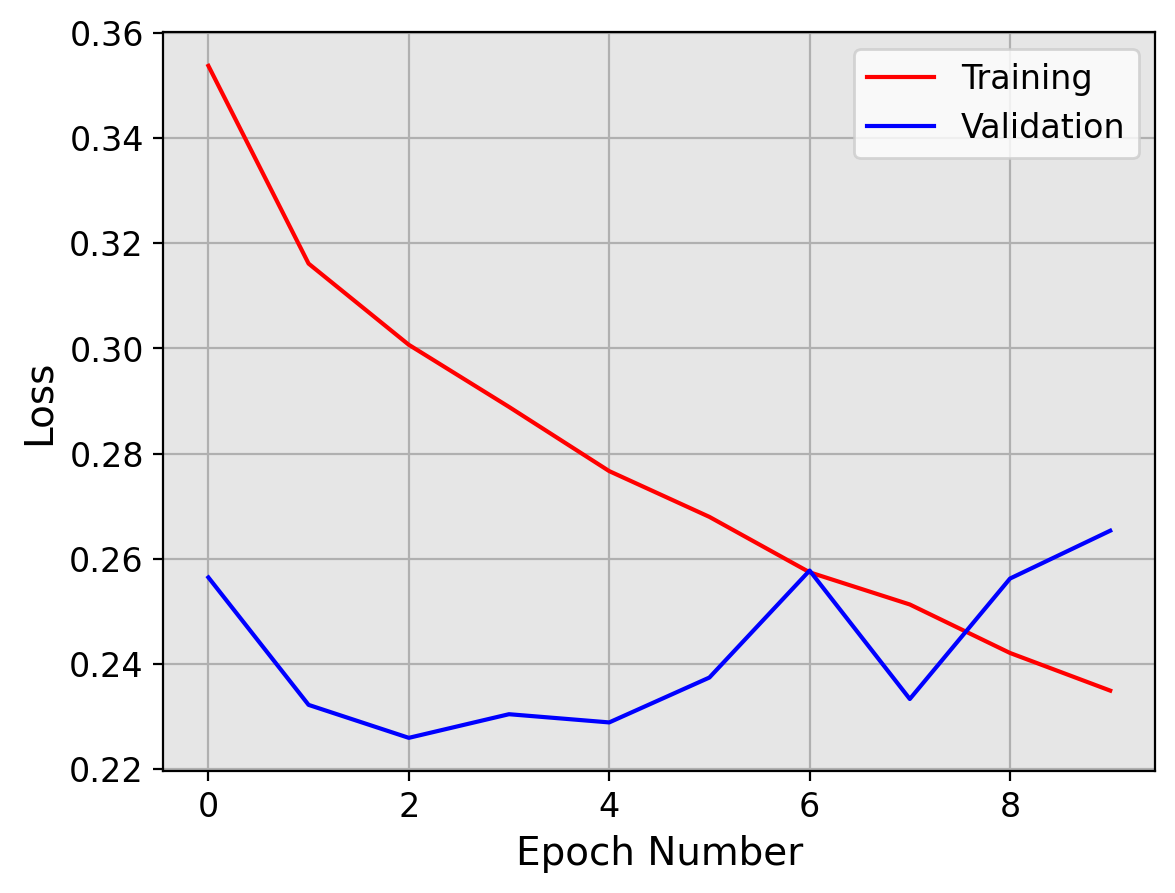

In [ ]:
plt.plot(train_losses, '-r', label='Training')
plt.plot(val_losses, '-b', label='Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()

Check the performance:

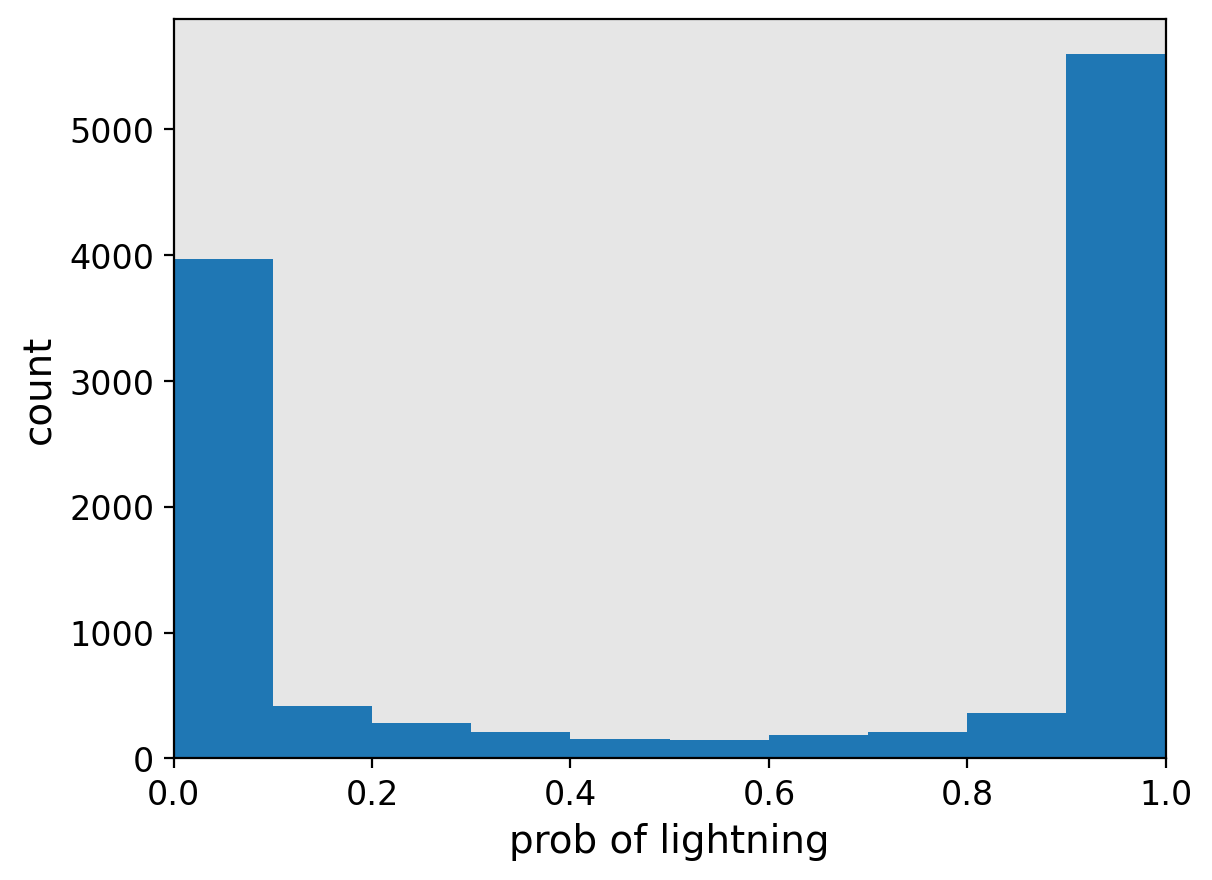

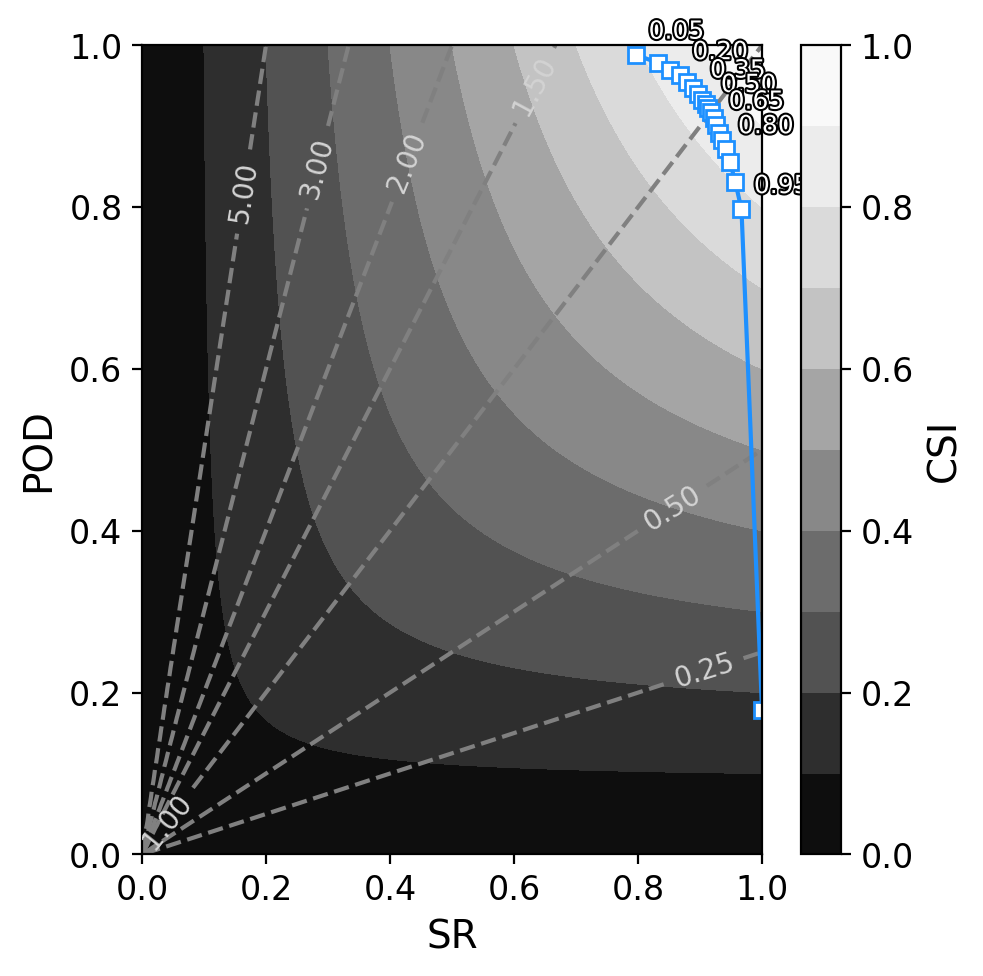

In [ ]:
# Get predictions
y_preds = get_predictions(val_loader, model)

plt.hist(y_preds)
plt.xlabel('prob of lightning')
plt.ylabel('count')
plt.xlim([0,1])

# Calculate performance diagram metrics
thresh = np.arange(0.05, 1.05, 0.05)

tps = []
fps = []
fns = []

for t in thresh:
    preds_bin = (y_preds >= t).astype(int)
    tps.append(np.sum((preds_bin == 1) & (y_v == 1)))
    fps.append(np.sum((preds_bin == 1) & (y_v == 0)))
    fns.append(np.sum((preds_bin == 0) & (y_v == 1)))

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)

pods = np.divide(tps, (tps + fns), out=np.zeros_like(tps, dtype=float), where=(tps + fns)!=0)
srs = np.divide(tps, (tps + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fps)!=0)
csis = np.divide(tps, (tps + fns + fps), out=np.zeros_like(tps, dtype=float), where=(tps + fns + fps)!=0)

#plot it up
ax = make_performance_diagram_axis()
ax.plot(srs, pods, '-s', color='dodgerblue', markerfacecolor='w', label='UNET')

for i, t in enumerate(thresh):
    if np.mod(i, 3) == 0:
        text = np.char.ljust(str(np.round(t, 2)), width=4, fillchar='0')
        ax.text(srs[i]+0.02, pods[i]+0.02, text, path_effects=pe1, fontsize=9, color='white')

plt.tight_layout()

**Exercise:** Add a convolutional layer to Step 11 and step through the rest of the notebook again. It's nontrivial to improve on a NN design, isn't it?

**Exercise:** How many tunable parameters are in SimpleCNN? (Hint: Refer to the figure; it is a more direct way to the answer than the code.)

 The next notebook will dive into using U-nets, which will not only tell us if there is lightning in the image but also where that lightning is.